# Below is the last successful running code

In [1]:
import Random
using Plots
using Statistics

const seed = Random.seed!(42)  # Fixing the overall seed for reproducible results by running the entire script.


function get_positive_energies()
    pos_ΔE = sort(unique(Int8[2*mid*(left+right+above+below) for mid=[-1, 1], left=[-1, 1], right=[-1, 1],
                    above=[-1, 1], below=[-1, 1] if 2*mid*(left + right + above + below) > 0]))
    return pos_ΔE
end


function get_acceptance_probabilities(beta::Float64, pos_ΔE::Array{Int8, 1})::Array{Float64, 1}
    acceptance_probabilities::Array{Float64, 1} = Float64[exp(-beta*ΔE) for ΔE in pos_ΔE]
    return acceptance_probabilities
end


function mc_step!(state::Array{Int8, 1}, pos_ΔE::Array{Int8, 1}, acceptance_probabilities::Array{Float64, 1}, skip::Int32)
    length = 30
    spins = length^2
    rand_sites = rand(seed, 1:spins, skip*spins)
    for site in rand_sites
        ΔE = 2 * state[site] * (state[mod1(site+length, spins)] + state[mod1(site-length, spins)] + 
            state[mod1(site+1, length) + ((site-1)÷length)*length] + 
            state[mod1(site-1, length) + ((site-1)÷length)*length])
        if ΔE > 0 && rand(seed) > acceptance_probabilities[findfirst(isequal(ΔE), pos_ΔE)]
            continue
        end
        state[site] *= -1
    end
    return
end


function ising2d(beta_values::Array{Float64, 1}, length::Int32, configurations::Int32, skip::Int32)
    spins::Int32 = length^2
    pos_ΔE::Array{Int8, 1} = get_positive_energies()
    mean_magnetization = Float64[]
    start = time()
    for beta in beta_values
        start2 = time()
        state = -ones(Int8, spins)
        acceptance_probabilities::Array{Float64, 1} = get_acceptance_probabilities(beta, pos_ΔE)
        magnetisation = sum(state)/spins  # Calculate the magnetisation apart so that it is immutable.
        magnetisation_values = Float64[magnetisation]
        for _ in 1:configurations
            mc_step!(state, pos_ΔE, acceptance_probabilities, skip)
            magnetisation = sum(state)/spins
            push!(magnetisation_values, magnetisation)
        end
        mean_value = abs(mean(magnetisation_values))
        push!(mean_magnetization, mean_value)

        elapsed = time() - start2
        println("β = ", beta, " with time = ", elapsed)
    end
    elapsed = time() - start
    println("Total time = ", elapsed)
    return mean_magnetization
end

ising2d (generic function with 1 method)

β = 0.0 with time = 2.2551581859588623
β = 0.04888888888888889 with time = 2.5242249965667725
β = 0.09777777777777778 with time = 2.803420066833496
β = 0.14666666666666667 with time = 3.058579921722412
β = 0.19555555555555557 with time = 3.2413270473480225
β = 0.24444444444444444 with time = 3.2913670539855957
β = 0.29333333333333333 with time = 3.277277946472168
β = 0.3422222222222222 with time = 3.2216410636901855
β = 0.39111111111111113 with time = 2.9750258922576904
β = 0.44 with time = 2.418213129043579
β = 0.44 with time = 2.4180099964141846
β = 0.44005263157894736 with time = 2.423938035964966
β = 0.4401052631578948 with time = 2.424997091293335
β = 0.4401578947368421 with time = 2.485166072845459
β = 0.44021052631578944 with time = 2.4122960567474365
β = 0.44026315789473686 with time = 2.468830108642578
β = 0.4403157894736842 with time = 2.4374210834503174
β = 0.4403684210526315 with time = 2.447701930999756
β = 0.44042105263157894 with time = 2.460703134536743
β = 0.4404736842

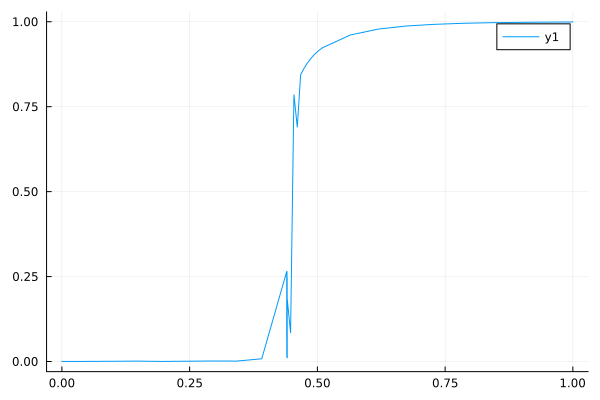

In [24]:
a = Float64[i/100 for i in range(0, 44, length=10)]
b = Float64[i/100 for i in range(44, 44.1, length=20)]
c = Float64[i/100 for i in range(44.1, 50, length=10)]
d = Float64[i/100 for i in range(51, 100, length=10)]
beta_values = Float64[a; b; c; d]

const length::Int32 =30
const configurations ::Int32 = 5000
const skip::Int32 = 40

mean_magnetization = ising2d(beta_values, length, configurations, skip)

plot(beta_values, mean_magnetization)

In [53]:
betas = range(0.5*log(1 + sqrt(2))+1e-15, 1, 100)

betas2 = range(0, 0.5*log(1 + sqrt(2)), 100)

z = exp.(-2. .* betas) 

m = (1 .+ z.^2).^(1/4) .* (1 .- 6*z.^2 .+ z.^4).^(1/8) ./ sqrt.(1 .- z.^2)

m_vs_beta = plot(beta_values, mean_magnetization, seriestype = :scatter, 
                 label="Simulated points", 
                 markersize=4., color="dodgerblue", 
                 xlabel="\$ \\beta = 1/k_{B} T \$ (in units of \$ 1/ J\$)", 
                 ylabel="\$ |\\langle M \\rangle| \$",
                 legend=:right, 
                 xticks = 0:0.1:1.,
                 dpi=1200)
plot!(betas, m, label = "Theoretical curve", color="red", linewidth=2.5)
plot!(betas2, [0 for _ in betas2], label=:false, color="red", linewidth=2.5)
plot!([0.5*log(1 + sqrt(2)) for _ in range(0, 1, 100)], range(0, 1, 100), linewidth=2.5,
      label="\$ \\beta_{c} = 1/k_{B}T_{c} \$")

savefig(m_vs_beta,"ising-2d.png")